In [49]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress

from utils import *

sns.set(style="whitegrid")

model_dir = "/Users/jessica.schmilovich/Documents/GSTEM Research Project/BehavioralModel-main/Fits"
behavior_dir = "/Users/jessica.schmilovich/Documents/GSTEM Research Project/BehVar-main/Rats"

In [50]:
rat_params = []

for fname in os.listdir(model_dir):
    if not fname.endswith(".mat"):
        continue

    rat_id = fname.replace("_Fits_NFoldCV.mat", "")
    mat_data = load_mat_file(os.path.join(model_dir, fname))
    bestfit_folds = mat_data["BestFit_Folds"]
    param_df = extract_bestfit_params(bestfit_folds)

    metrics = {"rat": rat_id}

    for param in ['param1', 'param2', 'param3', 'param4', 'param5']:
        values = param_df[param].values
        values_clean = remove_outliers_iqr(values)
        p_range = np.nanmax(values_clean) - np.nanmin(values_clean)
        p_median = np.nanmedian(values_clean)
        ratio = p_range / p_median if p_median != 0 else np.nan
        metrics[f'{param}_range'] = p_range
        metrics[f'{param}_range_over_median'] = ratio

    # Kappa differences
    k1_minus_k2 = remove_outliers_iqr(param_df['param1'] - param_df['param2'])
    k2_minus_k1 = remove_outliers_iqr(param_df['param2'] - param_df['param1'])
    k2_minus_k3 = remove_outliers_iqr(param_df['param2'] - param_df['param3'])

    for name, values in zip(['kappa_mixed_minus_high', 'kappa_high_minus_mixed', 'kappa_high_minus_low'],
                            [k1_minus_k2, k2_minus_k1, k2_minus_k3]):
        p_range = np.nanmax(values) - np.nanmin(values)
        p_median = np.nanmedian(values)
        ratio = p_range / p_median if p_median != 0 else np.nan
        metrics[f'{name}_range'] = p_range
        metrics[f'{name}_range_over_median'] = ratio

    rat_params.append(metrics)

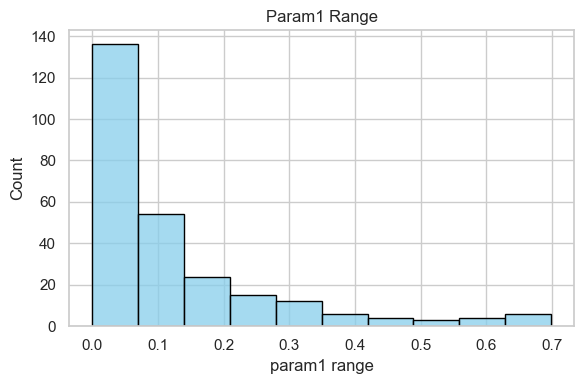

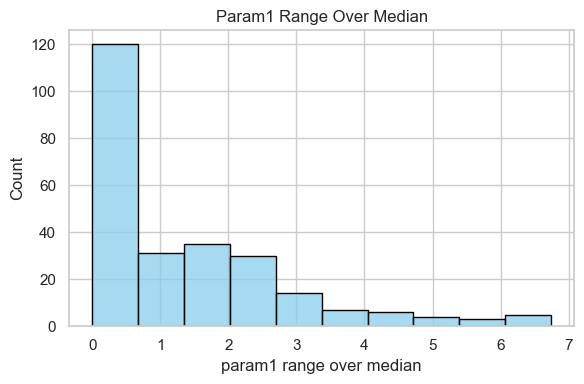

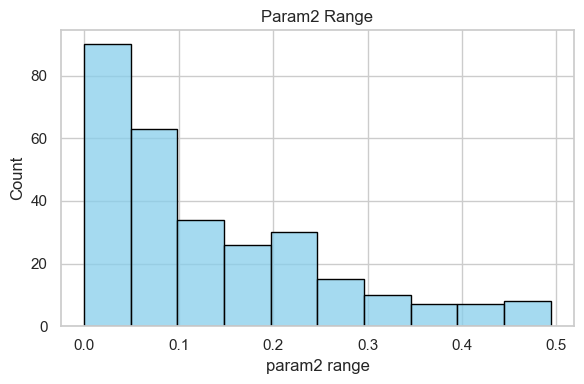

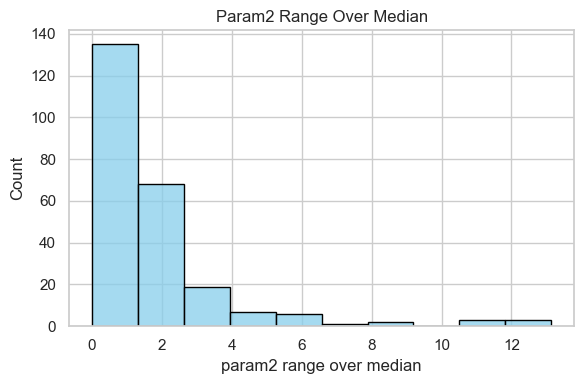

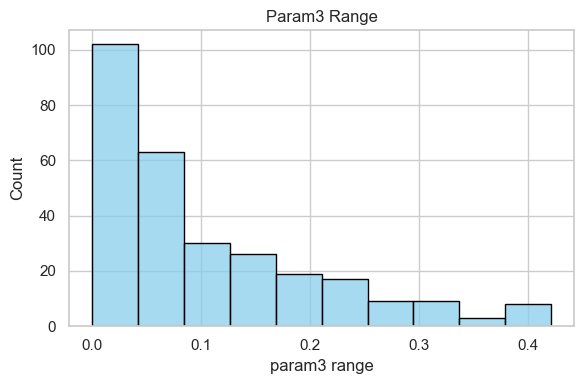

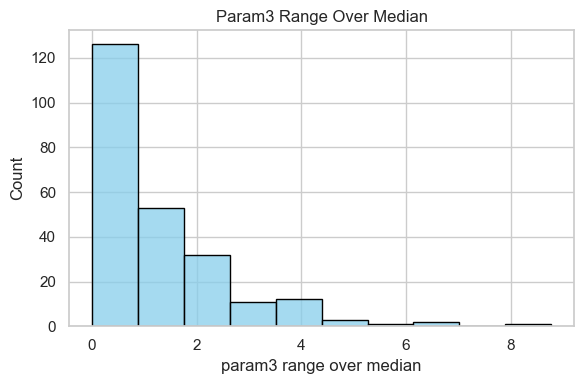

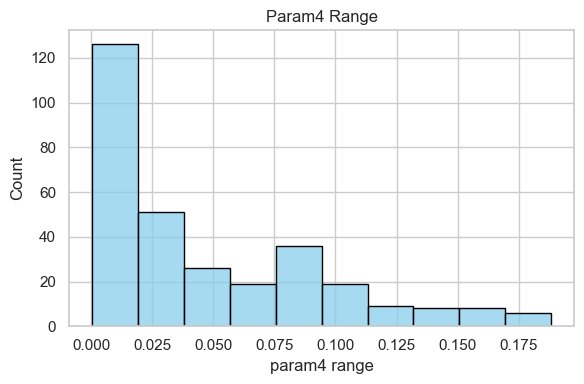

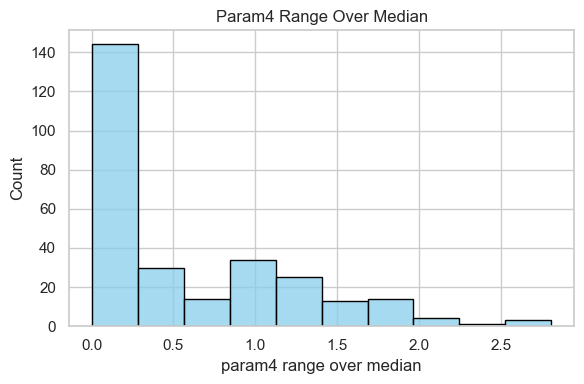

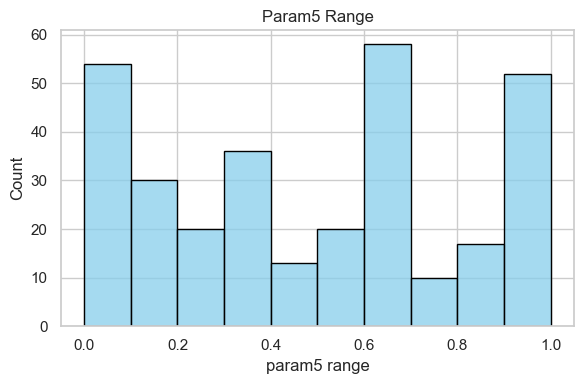

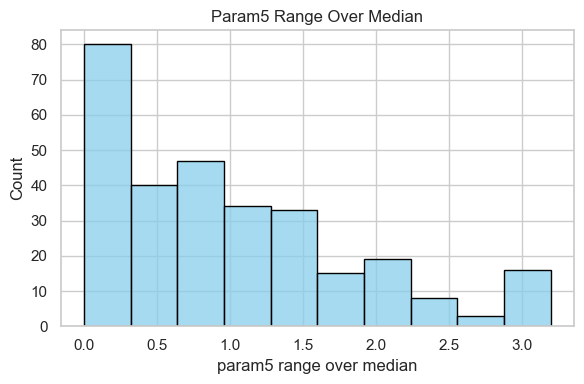

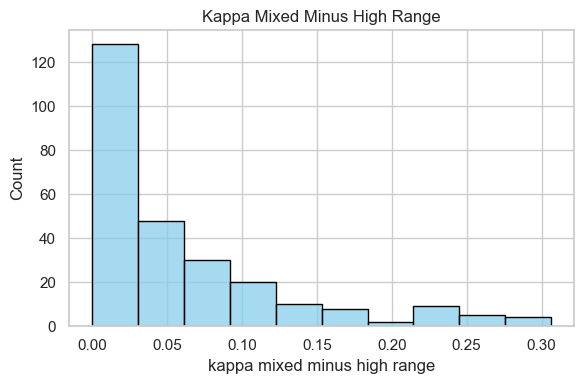

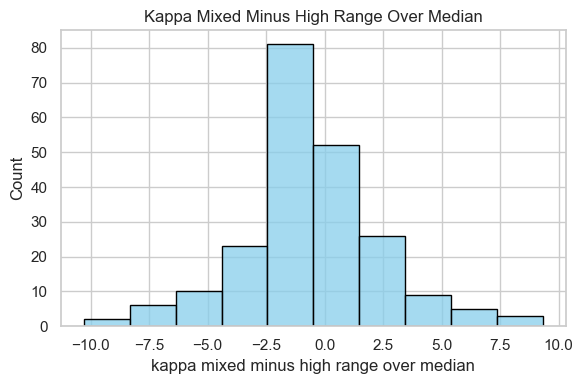

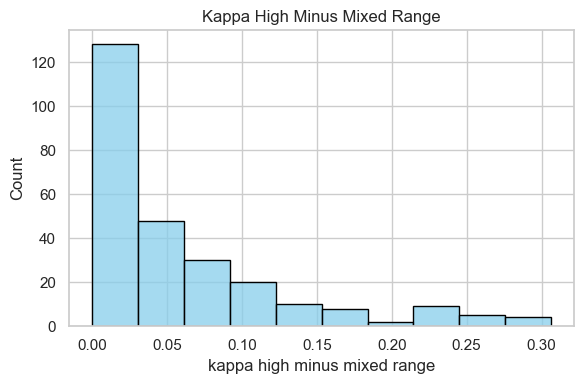

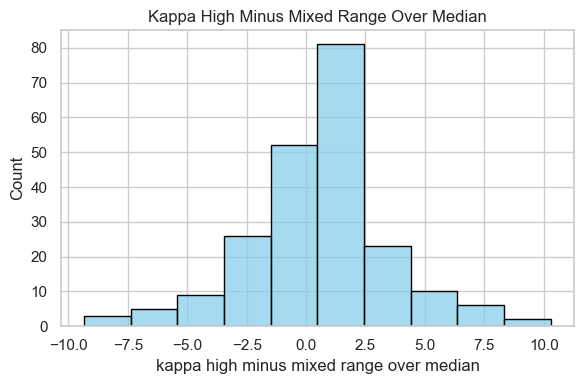

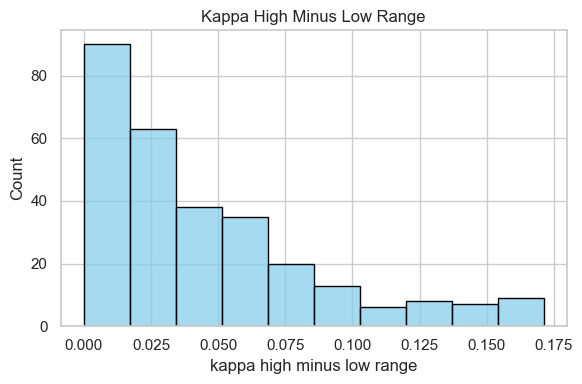

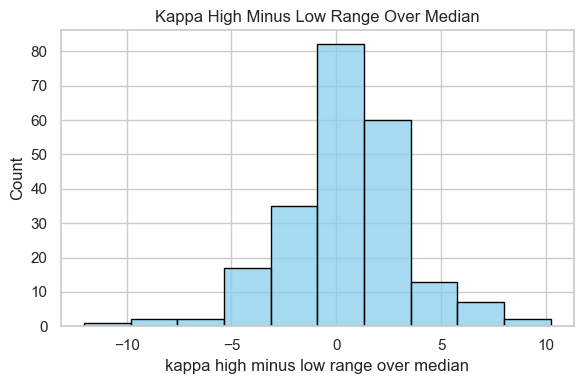

In [51]:
# convert to DataFrame
df_params = pd.DataFrame(rat_params)

for col in df_params.columns:
    if col == 'rat':
        continue
    cleaned = remove_plot_outliers(df_params[col], method='iqr', max_val=1e3)
    plt.figure(figsize=(6, 4))
    sns.histplot(cleaned, kde=False, color='skyblue', edgecolor='black', bins=10)
    plt.title(col.replace('_', ' ').title())
    plt.xlabel(col.replace('_', ' '))
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [52]:
mat_files = sorted(glob.glob(f"{model_dir}/*.mat"))

all_rat_data = {}

for file in mat_files:
    rat = os.path.basename(file).split('.')[0]
    mat_data = load_mat_file(file)
    folds = mat_data.get('BestFit_Folds', [])

    train_df = extract_train_trials(folds, rat=rat)
    test_df = extract_test_trials(folds, rat=rat)

    train_fold_0 = train_df[train_df['Fold'] == 0].copy()
    test_fold_0 = test_df[test_df['Fold'] == 0].copy()
    combined_df = pd.concat([train_fold_0, test_fold_0], ignore_index=True)

    ntrials = []
    if len(folds) > 0:
        f0 = folds[0]
        if hasattr(f0.ratTrial_TrainFold, 'ntrials'):
            ntrials.extend(f0.ratTrial_TrainFold.ntrials.flatten())
        if hasattr(f0.ratTrial_TestFold, 'ntrials'):
            ntrials.extend(f0.ratTrial_TestFold.ntrials.flatten())

    if len(ntrials) > 0:
        combined_df = add_session_numbers(combined_df, ntrials)
    else:
        combined_df['session'] = 1

    combined_df = combined_df.rename(columns={'session': 'session_num'})
    combined_df = get_transition_dynamics_from_df(combined_df)
    combined_df = apply_valid_trial_filter(combined_df)

    combined_df['z_wait_time'] = (
        combined_df.groupby('reward')['wait_time']
        .transform(lambda x: (x - x.mean()) / x.std())
    )
    combined_df['transition_type'] = identify_transition_types(combined_df)
    all_rat_data[rat] = combined_df

In [53]:
for file in mat_files:
    
    rat = os.path.basename(file).split('.')[0]
    mat_data = load_mat_file(file)
    folds = mat_data.get('BestFit_Folds', [])

    if len(folds) == 0:
        continue

    f0 = folds[0]
    model_train = getattr(f0.BestFit.Train, 'WTOpt', None)
    model_test = getattr(f0.BestFit.Test, 'WTOpt', None)

    if model_train is None or model_test is None:
        continue

    train_df = extract_train_trials(folds, rat=rat)
    test_df = extract_test_trials(folds, rat=rat)
    combined_df = pd.concat([
        train_df[train_df['Fold'] == 0],
        test_df[test_df['Fold'] == 0]
    ], ignore_index=True)

    combined_df["model_wait_time"] = np.concatenate([model_train, model_test])
    combined_df = apply_valid_trial_filter(combined_df)
    all_rat_data[rat] = combined_df

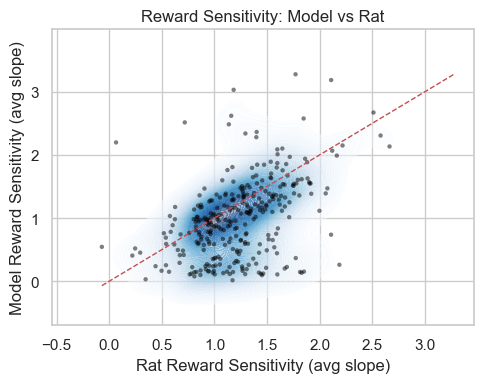

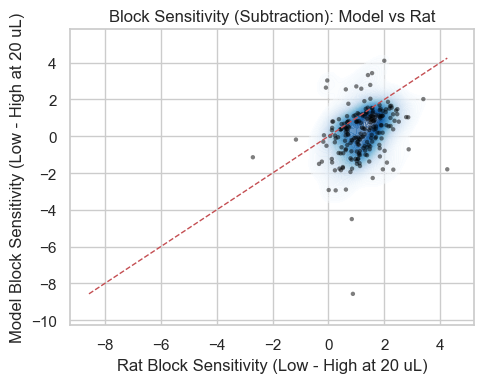

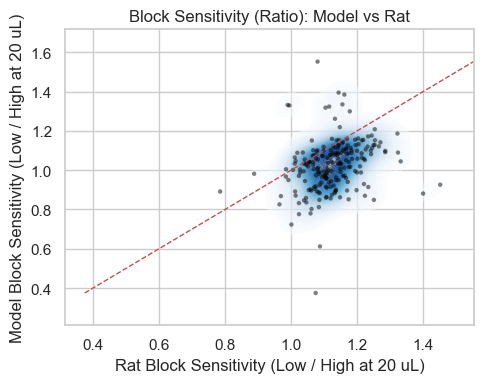

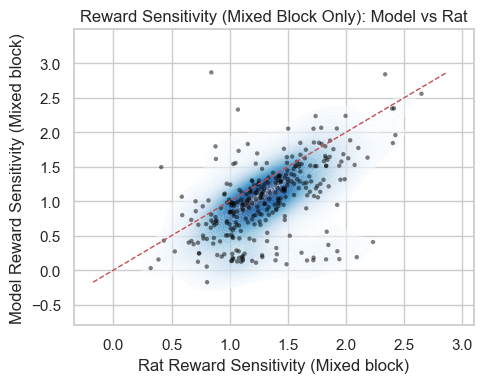

In [54]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

rat_names = []
rat_rew_sens = []
model_rew_sens = []
rat_block_diff = []
model_block_diff = []
rat_block_ratio = []
model_block_ratio = []

rat_mixed_sens = []
model_mixed_sens = []

for rat, combined_df in all_rat_data.items():
    if "model_wait_time" not in combined_df.columns:
        continue

    d = apply_valid_trial_filter(combined_df)
    d['log_reward'] = np.log(d['reward'])

    rat_slopes, model_slopes = [], []
    for block in [1, 2, 3]:
        db = d[d['block'] == block]
        if len(db) < 3:
            continue
        for col, slist in zip(['wait_time', 'model_wait_time'], [rat_slopes, model_slopes]):
            slope, _, _, _, _ = linregress(db['log_reward'], db[col])
            slist.append(slope)

    rat_rew_sens.append(np.nanmean(rat_slopes))
    model_rew_sens.append(np.nanmean(model_slopes))

    # Mixed block (block 1) sensitivity only
    mixed_block = d[d['block'] == 1]
    if len(mixed_block) >= 3:
        rat_mixed = linregress(mixed_block['log_reward'], mixed_block['wait_time'])[0]
        model_mixed = linregress(mixed_block['log_reward'], mixed_block['model_wait_time'])[0]
    else:
        rat_mixed = model_mixed = np.nan
    rat_mixed_sens.append(rat_mixed)
    model_mixed_sens.append(model_mixed)

    d20 = d[d['reward'] == 20]
    rat_low = d20[d20['block'] == 3]['wait_time']
    rat_high = d20[d20['block'] == 2]['wait_time']
    model_low = d20[d20['block'] == 3]['model_wait_time']
    model_high = d20[d20['block'] == 2]['model_wait_time']

    rat_block_diff.append(np.nanmean(rat_low) - np.nanmean(rat_high))
    model_block_diff.append(np.nanmean(model_low) - np.nanmean(model_high))
    rat_block_ratio.append(np.nanmean(rat_low) / np.nanmean(rat_high) if np.nanmean(rat_high) > 0 else np.nan)
    model_block_ratio.append(np.nanmean(model_low) / np.nanmean(model_high) if np.nanmean(model_high) > 0 else np.nan)
    rat_names.append(rat)

def plot_scatter(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(5, 4))
    sns.kdeplot(x=x, y=y, fill=True, cmap='Blues', alpha=0.4, bw_adjust=1, levels=100)
    plt.scatter(x, y, s=10, alpha=0.5, color='black', edgecolors='none')
    min_val = min(np.nanmin(x), np.nanmin(y))
    max_val = max(np.nanmax(x), np.nanmax(y))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_scatter(rat_rew_sens, model_rew_sens,
             "Reward Sensitivity: Model vs Rat",
             "Rat Reward Sensitivity (avg slope)", "Model Reward Sensitivity (avg slope)")

plot_scatter(rat_block_diff, model_block_diff,
             "Block Sensitivity (Subtraction): Model vs Rat",
             "Rat Block Sensitivity (Low - High at 20 uL)", "Model Block Sensitivity (Low - High at 20 uL)")

plot_scatter(rat_block_ratio, model_block_ratio,
             "Block Sensitivity (Ratio): Model vs Rat",
             "Rat Block Sensitivity (Low / High at 20 uL)", "Model Block Sensitivity (Low / High at 20 uL)")

# plot for just Mixed block
plot_scatter(rat_mixed_sens, model_mixed_sens,
             "Reward Sensitivity (Mixed Block Only): Model vs Rat",
             "Rat Reward Sensitivity (Mixed block)", "Model Reward Sensitivity (Mixed block)")

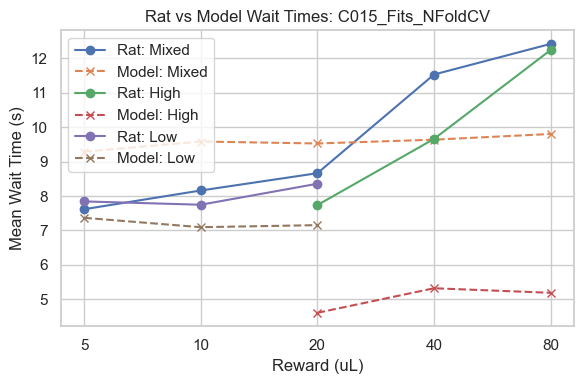

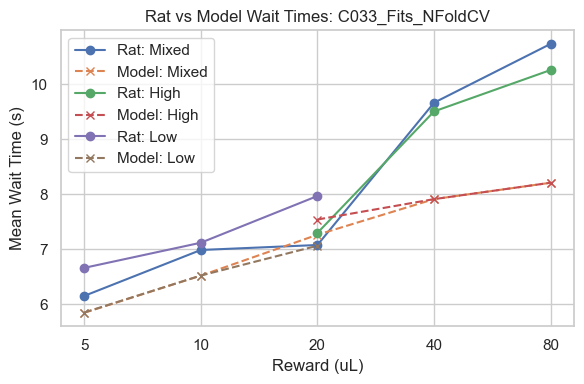

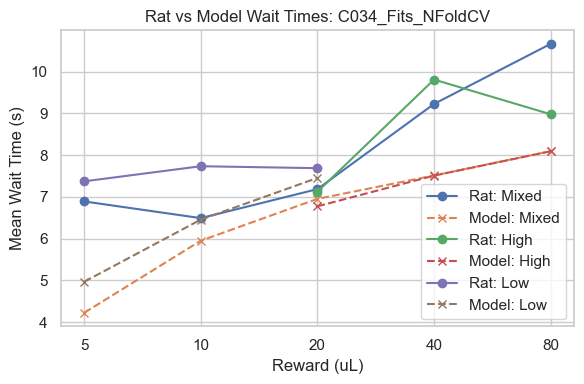

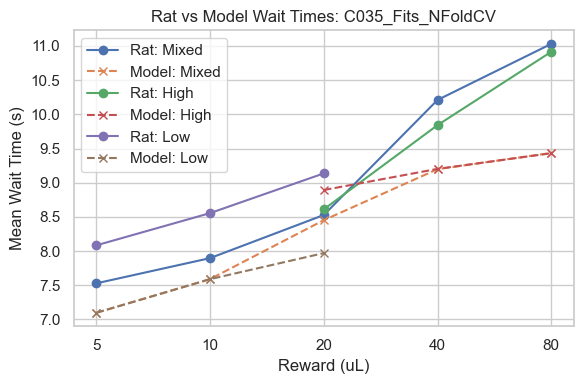

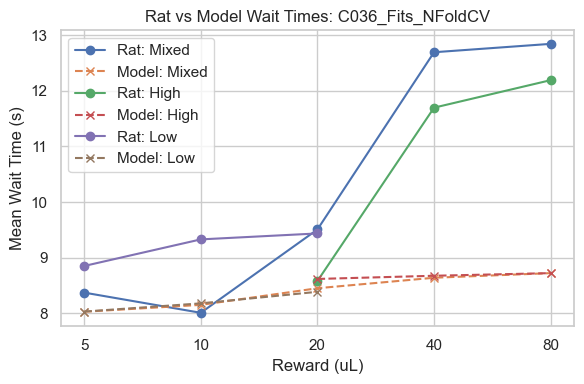

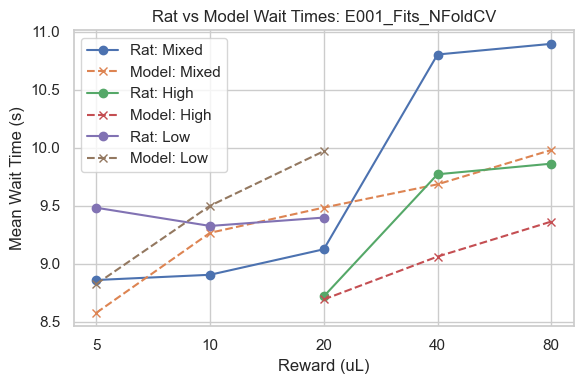

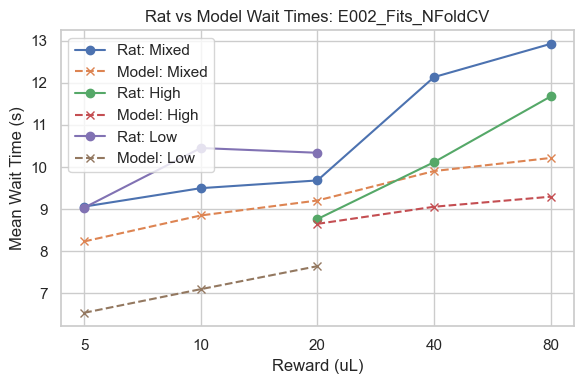

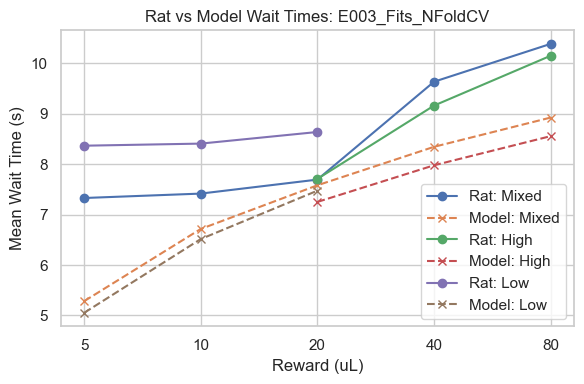

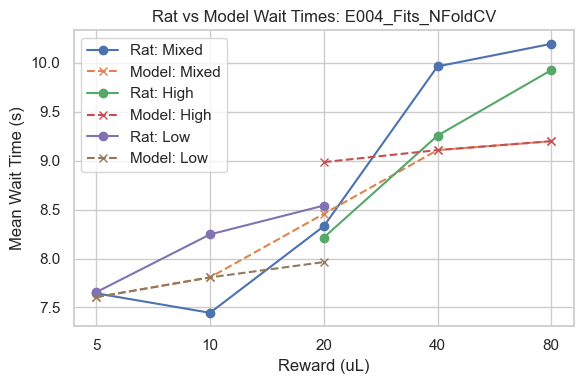

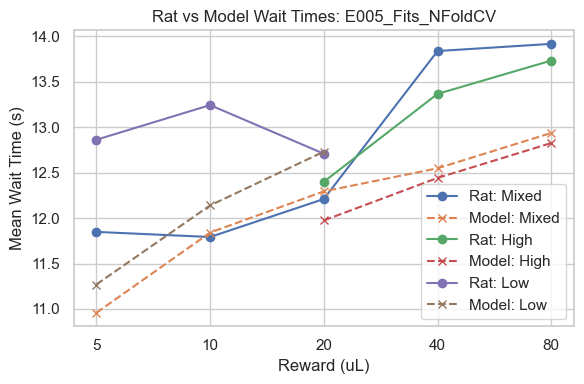

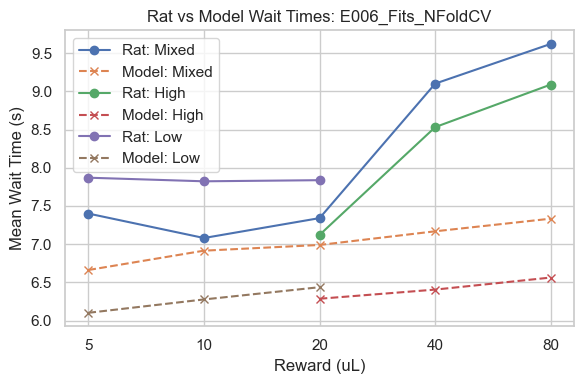

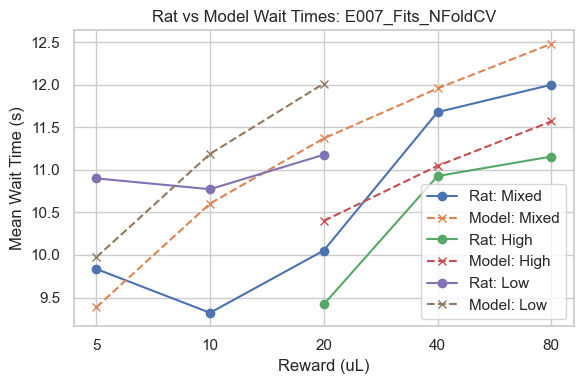

In [55]:
block_map = {1: "Mixed", 2: "High", 3: "Low"}
reward_label_map = {4: 5, 8: 10, 16: 20, 32: 40, 64: 80}

shown = 0
for rat, combined_df in all_rat_data.items():
    if shown >= 12:
        break

    blocks = sorted(combined_df['block'].dropna().unique())
    rewards = sorted(combined_df['reward'].dropna().unique())
    fig, ax = plt.subplots(figsize=(6, 4))

    for block in blocks:
        block_name = block_map.get(int(block), f"Block {block}")
        mean_rat, mean_model = [], []

        for reward in rewards:
            sel = (
                    (combined_df['block'] == block) &
                    (combined_df['reward'] == reward) &
                    (combined_df['vios'] == 0) &
                    (combined_df['optout'] == 1) &
                    (combined_df['wait_time'] <= 30)
            )
            rat_vals = combined_df.loc[sel, 'wait_time']
            model_vals = combined_df.loc[sel, 'model_wait_time']
            mean_rat.append(np.nanmean(rat_vals) if len(rat_vals) else np.nan)
            mean_model.append(np.nanmean(model_vals) if len(model_vals) else np.nan)

        ax.plot(rewards, mean_rat, label=f"Rat: {block_name}", linestyle='-', marker='o')
        ax.plot(rewards, mean_model, label=f"Model: {block_name}", linestyle='--', marker='x')

    ax.set_xscale("log")
    ax.set_xticks(rewards)
    ax.set_xticklabels([str(reward_label_map.get(r, int(r))) for r in rewards])
    ax.set_xlabel("Reward (uL)")
    ax.set_ylabel("Mean Wait Time (s)")
    ax.set_title(f"Rat vs Model Wait Times: {rat}")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    shown += 1